# Data-analysis, group 3
Our subjects: 3,5,11,17,19,25,31,33

In [35]:
# imports and stuff
from dataclasses import dataclass
from typing import List, Optional
import matplotlib.pyplot as plt
from os.path import join as pj
import scipy.io as io
import pandas as pd
import numpy as np
import uneye
import math
import csv


## 1. Reading the data

In [36]:
# constants and helper variables
subjects = [3, 5, 11, 17, 19, 25, 31, 33]
subjects_formatted = ['s' + str(s) for s in subjects]


In [37]:
@dataclass
class Sample:
    """Class for a sample from the data"""
    sid: str
    known: bool
    xi: Optional[List[float]] = None
    yi: Optional[List[float]] = None


In [38]:
def parse_line(line) -> List:
    return line.split(',')


def parse_classes(lines) -> List[Sample]:
    parsed_lines = [parse_line(line) for line in lines]
    return [Sample(line[0], line[1], line[2::2], line[3::2]) for line in parsed_lines]


In [39]:
# reading the lines
with open('data/train.csv') as f:
    lines = f.readlines()

    our_lines = [line for line in lines
                 if line.split(',')[0]
                 in subjects_formatted]

    samples = parse_classes(our_lines)

    sample_dict = {}

    for sample in samples:
        sample_dict.setdefault(sample.sid, []).append(sample)

    for key, val in sample_dict.items():
        print(key, len(val))


s5 34
s17 23
s19 14
s31 33
s3 29
s11 10
s25 17
s33 33


## 2. Fixation detection algorithm

In [40]:
def get_dispersion(x, y):
    """Calculate dispersion, idea from: https://github.com/ecekt/eyegaze

    Args:
        x (numpy array): x coordinates
        y (numpy array): y coordinates

    Returns:
        float: amount of dispersion
    """
    x = np.array(x)
    y = np.array(y)

    return ((np.max(x.astype(float)) - np.min(x.astype(float)))
            + (np.max(y.astype(float)) - np.min(y.astype(float))))/2


In [41]:
#uneye-palikka

model = uneye.DNN(max_iter=500, sampfreq=1000,
            lr=0.001, weights_name='weights',
            min_sacc_dist=1,min_sacc_dur=6,augmentation=True,
            ks=5,mp=5,inf_correction=1.5,val_samples=30)

# train
for subject, sample_list in sample_dict.items():
    for sample in sample_list:
        model.train(sample.xi, sample.yi, sample.known)

# plot loss
import matplotlib.pyplot as plt
f = plt.figure(figsize=(4,3))
plt.plot(model.loss_train,label='training')
plt.plot(model.loss_val,label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and test loss')
plt.legend()
plt.tight_layout()
plt.show()

# predict with trained
for subject, sample_list in sample_dict.items():
    for sample in sample_list:
        Prediction,Probability = (sample.xi, sample.yi, sample.known)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
def idt(x, y, t, max_disp=10, min_dur=50000):

    # helper variables
    fixations = []
    fixation_durations = []
    centroid_x = []
    centroid_y = []
    i = 0
    last = 0

    # loop points
    while(i < len(x)):
        
        # reset variables
        dispersion = 0.0
        window = []

        # add first timepoint
        window.append(t[last])

        last_time = t[last]
        start_time = last_time

        y_fixations = []
        x_fixations = []

        # Initialize window over first points to cover the duration threshold
        while((start_time + min_dur) >= last_time and last + 1 < len(x)):
            x_fixations.append(x[last])
            y_fixations.append(y[last])

            last = last + 1
            last_time = t[last]

        # If dispersion of window points <= threshold  
        if len(x_fixations) > 0 and get_dispersion(x_fixations, y_fixations) <= max_disp:

            # Add additional points to the window until dispersion > threshold  
            while (dispersion <= max_disp and last + 1 < len(x)):
                x_fixations.append(x[last])
                y_fixations.append(y[last])

                dispersion = get_dispersion(x_fixations, y_fixations)

                last = last + 1
                last_time = t[last]

            # add window to the fixations :D
            window.append(last_time)
            fixations.append(window)
            
            # Centroid x- and y-coordinates
            x_fixations = np.array(x_fixations).astype(float)
            y_fixations = np.array(y_fixations).astype(float)
            centroid_x.append(np.mean(x_fixations))
            centroid_y.append(np.mean(y_fixations))
            
            # Fixation durations
            duration = (window[1] - window[0]) / 1000
            fixation_durations.append(duration)
            
            # Remove window points from points  
            i = last           
        else:
            #print("dispersion liikaa lol", last, i)
            # Remove first point from points 
            i = i + 1

    # return fixation points
    return fixations, fixation_durations, zip(centroid_x, centroid_y)


## 3. Data-analysis

In [59]:
def mfd(fixation_durations):
    return np.mean(fixation_durations)


def get_saccade_amplitude(fix1, fix2):
    """
    Yksittäisen saccaden amplitudi radiaaneina(?)
    """
    return (2 * (1 - np.dot(fix1, fix2) / (np.dot(fix1, fix1) * np.dot(fix2, fix2)) ** 0.5)) ** 0.5


def msa(fixations):
    return np.mean([get_saccade_amplitude(fixations[i - 1], fixations[i]) for i in range(1, len(fixations))])


def get_statistics(list):
    # returns mean and standard deviation
    return np.mean(list), np.std(list)


In [60]:
@dataclass
class Result:
    """Luokka lasketuille tuloksille, josta on helppo muodostaa rivi csv-tiedostoon"""

    sid: str
    mfd_true: float
    mfd_sd_true: float
    mfd_false: float
    mfd_sd_false: float
    msa_true: float
    msa_sd_true: float
    msa_false: float
    msa_sd_false: float
    mfd_overall: float
    mfd_overall_sd: float
    msa_overall: float
    msa_overall_sd: float

    def to_csv_row(self):
        return [
            self.sid,
            self.mfd_true,
            self.mfd_sd_true,
            self.mfd_false,
            self.mfd_sd_false,
            self.msa_true,
            self.msa_sd_true,
            self.msa_false,
            self.msa_sd_false,
            self.mfd_overall,
            self.mfd_overall_sd,
            self.msa_overall,
            self.msa_overall_sd
        ]


In [61]:
sid_MFD_MSA = {}
I_KNOWN = 0
I_MFD = 1
I_MSA = 2

sampfreq = 1000
sampling_period = int(1 / sampfreq * 10**6)

# iterate samples per subject
for subject, sample_list in sample_dict.items():
    for sample in sample_list:

        # Artificial timeline in microseconds
        t = np.arange(0, len(sample.xi) * sampling_period, sampling_period)

        fixations, fixation_durations, centroids = idt(
            sample.xi, sample.yi, t, 50, 100000)

        MFD = mfd(fixation_durations)
        MSA = msa(list(centroids))

        # Jotain luettavaa ettei kyllästy
        #print(f'Subject {subject} MFD for this sample: {MFD:.1f}')
        sid_MFD_MSA.setdefault(subject, []).append((sample.known, MFD, MSA))


In [62]:
results = []

for sid, samples in sid_MFD_MSA.items():
    # samples
    samples_known_true = [i for i in samples if i[I_KNOWN] == 'true']
    samples_known_false = [i for i in samples if i[I_KNOWN] == 'false']

    # mean fixation detection
    mfd_true, mfd_sd_true = get_statistics([i[I_MFD] for i in samples_known_true])
    mfd_false, mfd_sd_false = get_statistics([i[I_MFD] for i in samples_known_false])
    mfd_overall, mfd_sd_overall = get_statistics([i[I_MFD] for i in samples])
    
    # mean saccade amplitude
    msa_true, msa_sd_true = get_statistics([i[I_MSA] for i in samples_known_true])
    msa_false, msa_sd_false = get_statistics([i[I_MSA] for i in samples_known_false])
    msa_overall, msa_sd_overall = get_statistics([i[I_MSA] for i in samples])
    
    # new object/row to the csv from the calculations
    result = Result(
        sid, 
        mfd_true, mfd_sd_true, 
        mfd_false, mfd_sd_false, 
        msa_true, msa_sd_true, 
        msa_false, msa_sd_false, 
        mfd_overall, mfd_sd_overall, 
        msa_overall, msa_sd_overall
    )
    
    results.append(result)
    

results = sorted(results, key=lambda x: int(x.sid[1:]))    

In [63]:
results

[Result(sid='s3', mfd_true=219.56494708994708, mfd_sd_true=67.02805229438385, mfd_false=204.29916666666668, mfd_sd_false=41.72956077364236, msa_true=1.0316014949467334, msa_sd_true=0.24650182556381936, msa_false=1.237965401019861, msa_sd_false=0.3002033627072572, mfd_overall=209.0368226600985, mfd_overall_sd=51.43071781665838, msa_overall=1.17392143016958, msa_overall_sd=0.30020893927359377),
 Result(sid='s5', mfd_true=178.23090277777774, mfd_sd_true=27.468520832816292, mfd_false=205.85205627705633, mfd_sd_false=39.37667591755229, msa_true=1.3399190016708535, msa_sd_true=0.4525682911856344, msa_false=1.272825892600097, msa_sd_false=0.47965801773994077, mfd_overall=196.10341386554623, mfd_overall_sd=37.99754072767264, msa_overall=1.2965058134485994, msa_overall_sd=0.47136688954817374),
 Result(sid='s11', mfd_true=199.64682539682542, mfd_sd_true=40.4968071132696, mfd_false=177.0125, mfd_sd_false=29.206599746461418, msa_true=0.990813582831105, msa_sd_true=0.1262416063645784, msa_false=1.1

## 4. CSV-file from the analysed data

In [64]:
header = [
    'subject_id',
    'MFD_true',
    'MFD_SD_true',
    'MFD_false',
    'MFD_SD_false',
    'MSA_true',
    'MSA_SD_true',
    'MSA_false',
    'MSA_SD_false',
    'MFD_overall',
    'MFD_overall_SD',
    'MSA_overall',
    'MSA_overall_SD',
]


In [65]:
# kirjoitellaan csv-tiedosto
with open("./results_group_3.csv", "w", encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([i.lower().strip() for i in header])
    writer.writerows([r.to_csv_row() for r in results])


In [66]:
# Get the data from results:DD
# Keksikää tälle joku fiksumpi toteutus, väänsin vaa väkisin ku ei jaksanu miettii:D
# tässä vois ottaa pandasilla dataframen tuosta csv-tiedostosta mut tää on varmaan ihan pätevä tähän :D
labels = [result.sid for result in results]
mfd_true = [result.mfd_true for result in results]
mfd_sd_true = [result.mfd_sd_true for result in results]
mfd_false = [result.mfd_false for result in results]
mfd_sd_false = [result.mfd_sd_false for result in results]
msa_true = [result.msa_true for result in results]
msa_sd_true = [result.msa_sd_true for result in results]
msa_false = [result.msa_false for result in results]
msa_sd_false = [result.msa_sd_false for result in results]
mfd_overall = [result.mfd_overall for result in results]
mfd_overall_sd = [result.mfd_overall_sd for result in results]
msa_overall = [result.msa_overall for result in results]
msa_overall_sd = [result.msa_overall_sd for result in results]

## 5. Visualization and plots

Use charts so that you can indicate standard deviation or standard error of the mean (SEM) as +-error bars. 

**Important**: compare the known=true and known=false conditions (for aggregated data of all your subjects), and discuss eventual differences briefly. 

You may add other visualizations, for example a scatter plot of MSA x MFD. **The goal is to show insights into the data.**

<ipython-input-69-a3cbc57a8f8c>:31: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(x_label_loc, labels)
<ipython-input-69-a3cbc57a8f8c>:38: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks(x_label_loc, labels)


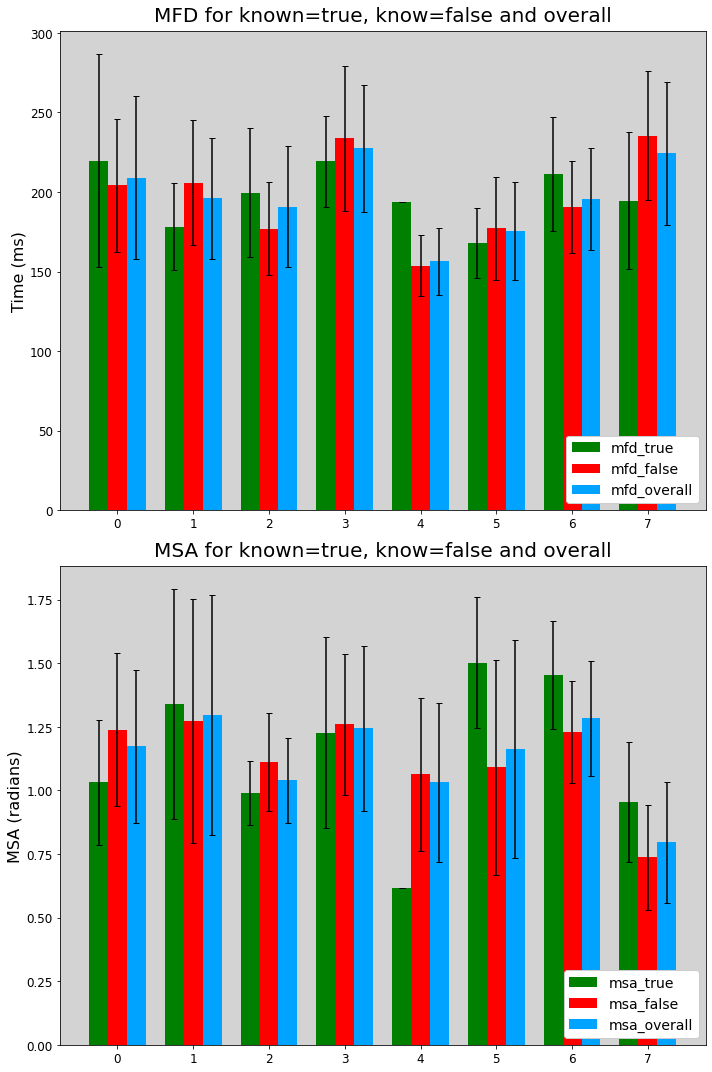

In [69]:
# Bar plots for MDF and MSA

x_label_loc = np.arange(len(labels))
bar_width = 0.25

fig, ax = plt.subplots(2, 1, figsize=(10,15))

# Bars for MFD plot
rects1 = ax[0].bar(x_label_loc - bar_width, mfd_true, bar_width,
                yerr=mfd_sd_true, capsize=3, label='mfd_true', color='green')

rects2 = ax[0].bar(x_label_loc, mfd_false, bar_width,
                yerr=mfd_sd_false, capsize=3, label='mfd_false', color='red')

rects3 = ax[0].bar(x_label_loc + bar_width, mfd_overall, bar_width,
                yerr=mfd_overall_sd, capsize=3, label='mfd_overall', color='#00A3FF')

# Bars for MSA plot
rects4 = ax[1].bar(x_label_loc - bar_width, msa_true, bar_width,
                yerr=msa_sd_true, capsize=3, label='msa_true', color='green')

rects5 = ax[1].bar(x_label_loc, msa_false, bar_width,
                yerr=msa_sd_false, capsize=3, label='msa_false', color='red')

rects6 = ax[1].bar(x_label_loc + bar_width, msa_overall, bar_width,
                yerr=msa_overall_sd, capsize=3, label='msa_overall', color='#00A3FF')

# Labels & stuff
ax[0].set_ylabel('Time (ms)', fontsize=16)
ax[0].set_title('MFD for known=true, know=false and overall', fontsize=20, pad=10)
ax[0].set_xticks(x_label_loc, labels)
ax[0].legend(loc='lower right', framealpha=1, fontsize=14)
ax[0].set_facecolor('lightgrey')
ax[0].tick_params(axis='both', which='major', labelsize=12)

ax[1].set_ylabel('MSA (radians)', fontsize=16)
ax[1].set_title('MSA for known=true, know=false and overall', fontsize=20, pad=10)
ax[1].set_xticks(x_label_loc, labels)
ax[1].legend(loc='lower right', framealpha=1, fontsize=14)
ax[1].set_facecolor('lightgrey')
ax[1].tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()

plt.show()

fig.savefig('./plots/MFD_MSA.png')

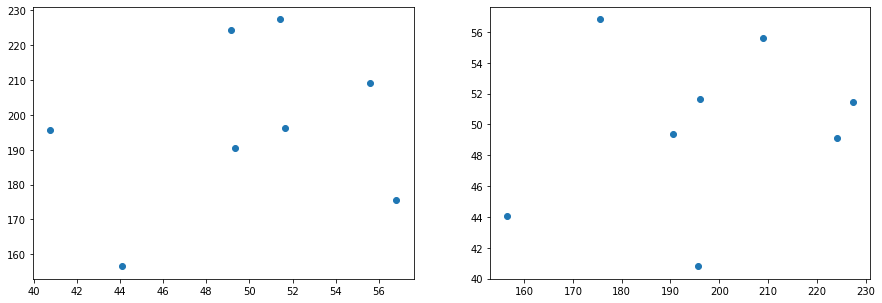

In [ ]:
# Nää ei kyl kerro yhtää mitään, pitää katella jotai muuta
# jep
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].scatter(msa_overall, mfd_overall)
ax[1].scatter(mfd_overall, msa_overall)